In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import torch.optim as optim

In [2]:
import matplotlib
import numpy
import os
if 'DISPLAY' not in os.environ:
    print('Cannot display picture')
    matplotlib.use('Agg')
from matplotlib import pyplot as plt
from torchvision import utils
show_image=True
def imshow(inp, file_name, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(10, 10))
    inp = inp.numpy().transpose((1, 2, 0))
    inp[inp>1]=1
    inp[inp<-1]=-1
    plt.imshow(inp)
    plt.savefig(file_name)
    if show_image:
        plt.show()
    else:
        print("Don't show")

In [3]:
root = './data'
download = True
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5))])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)
batch_size = 128
kwargs = {}
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [4]:
z_size=128
hidden_size=128
img_size=28

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_size, hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size*2, hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(hidden_size*4, hidden_size*8),
#             nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size*4, img_size**2),
            nn.Tanh()
        )
    def forward(self, x):
        x = x.view(x.size()[0], z_size)
        out = self.model(x)
        out = out.view(x.size()[0], 1,img_size,img_size)
        return out

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size**2, hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
#             nn.Linear(hidden_size*8, hidden_size*4),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
            nn.Linear(hidden_size*4, hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size*2, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        out = self.model(x.view(x.size(0), img_size**2))
        out = out.view(out.size(0), -1)
        return out

  0%|          | 0/10001 [00:00<?, ?it/s]

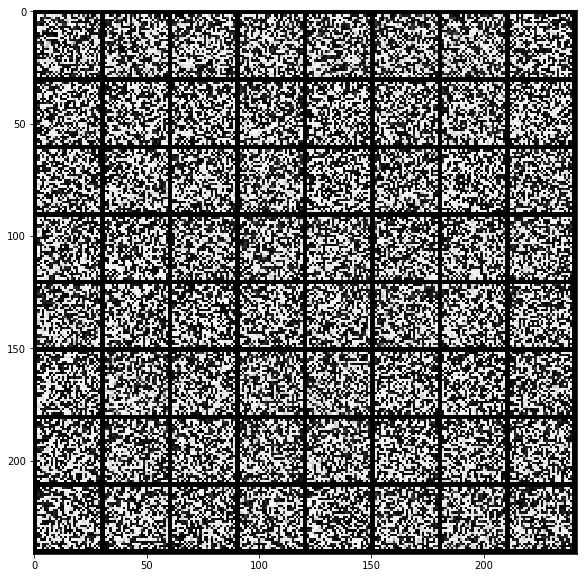

 10%|▉         | 1000/10001 [02:10<19:32,  7.68it/s]

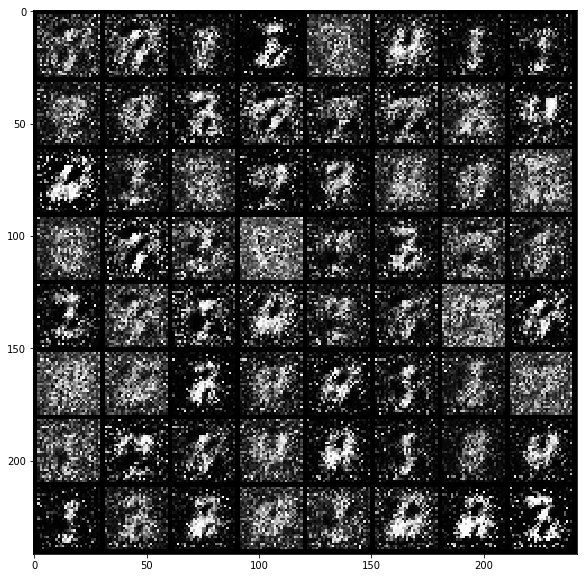

 20%|█▉        | 2000/10001 [04:07<16:28,  8.09it/s]

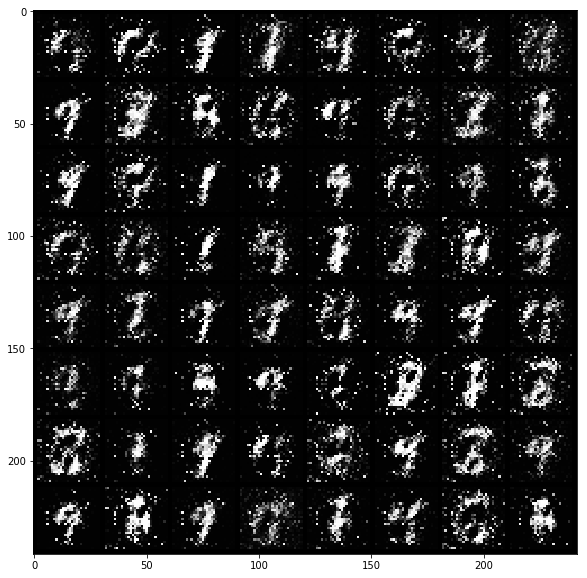

 30%|██▉       | 3000/10001 [06:21<14:50,  7.87it/s]

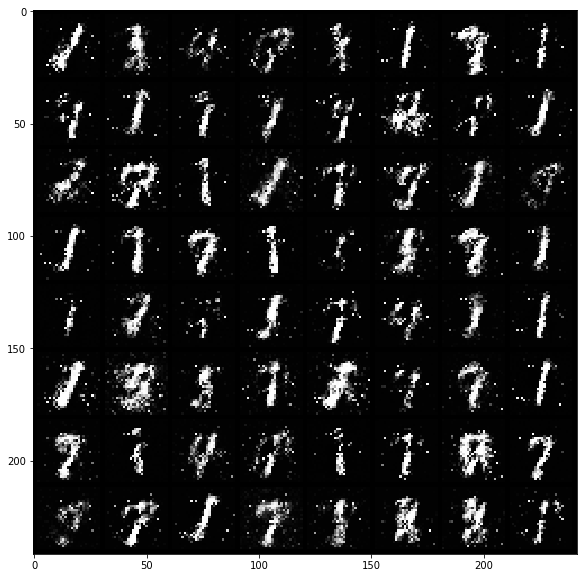

 40%|███▉      | 4000/10001 [08:28<12:42,  7.87it/s]

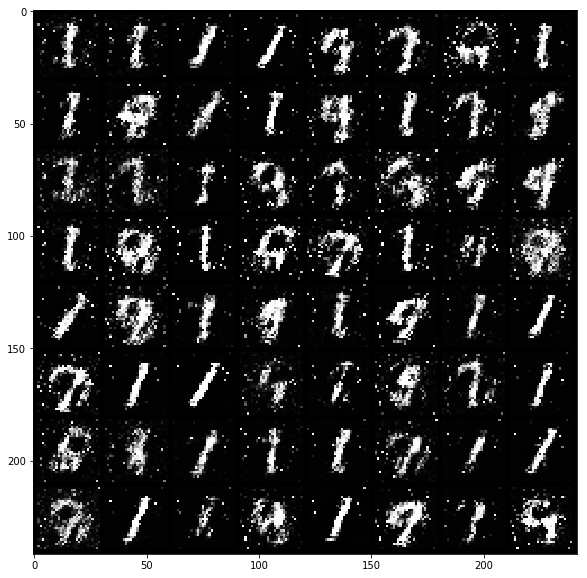

 50%|████▉     | 5000/10001 [10:27<10:27,  7.97it/s]

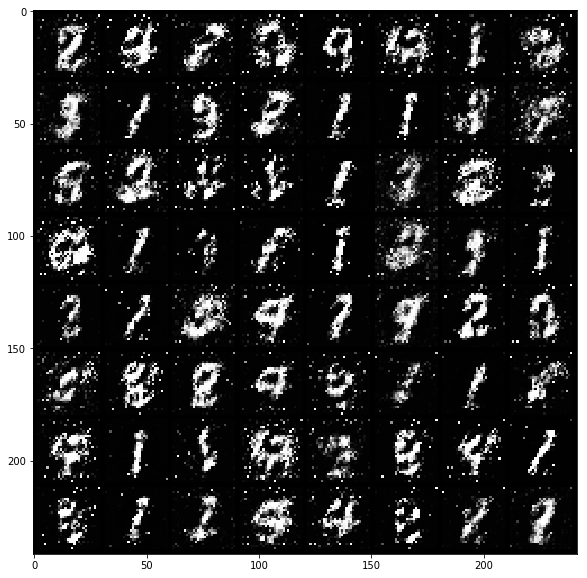

 60%|█████▉    | 6000/10001 [12:35<08:23,  7.94it/s]

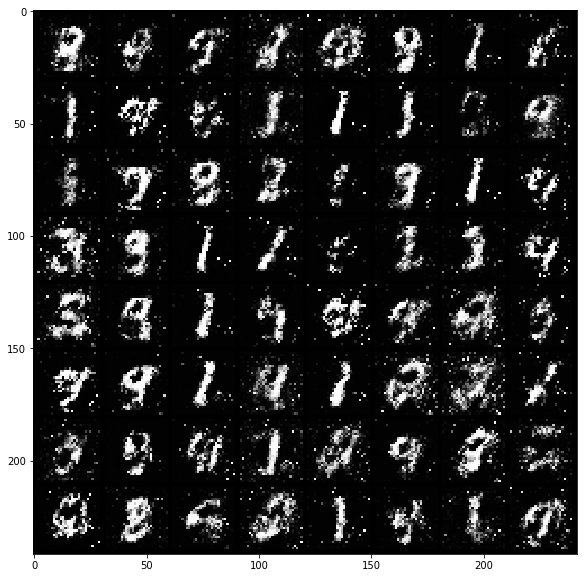

 70%|██████▉   | 7000/10001 [14:43<06:18,  7.93it/s]

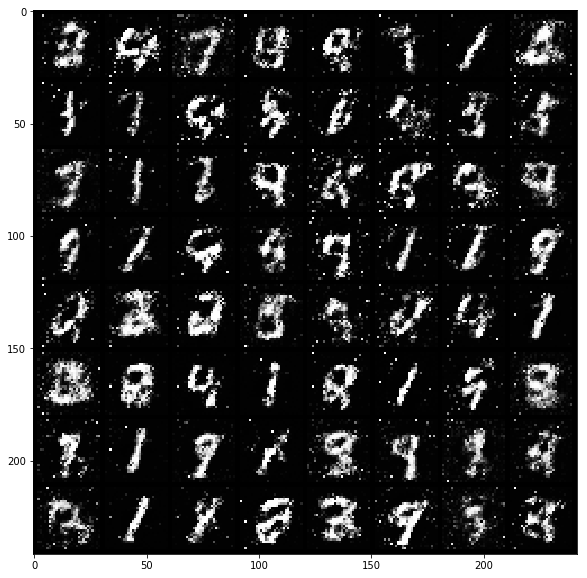

 80%|███████▉  | 8000/10001 [17:10<04:17,  7.76it/s]

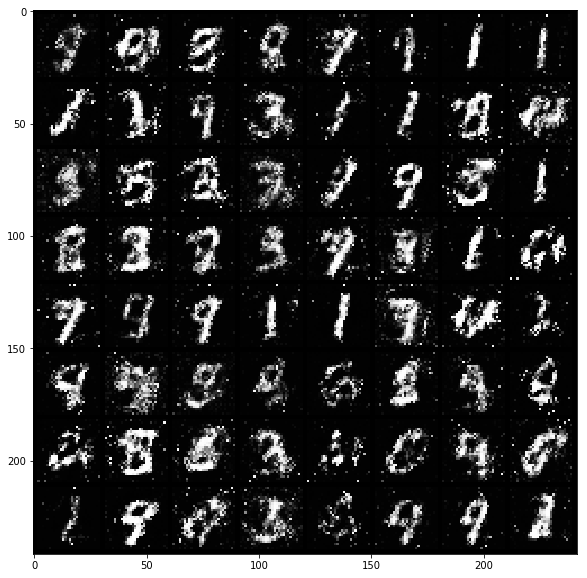

 90%|████████▉ | 9000/10001 [19:20<02:09,  7.75it/s]

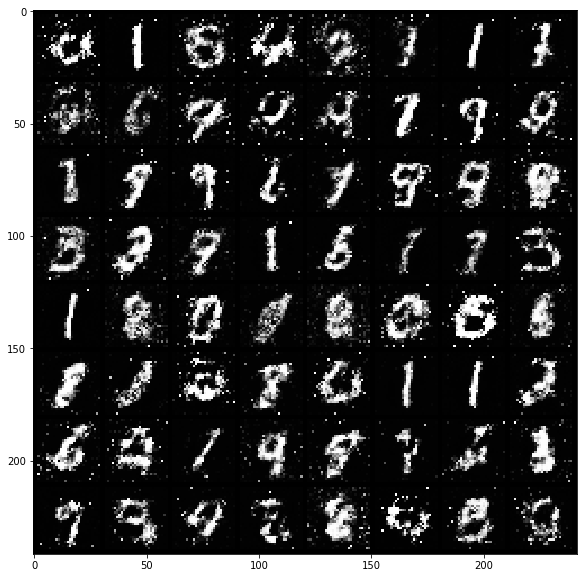

100%|█████████▉| 10000/10001 [21:36<00:00,  7.72it/s]

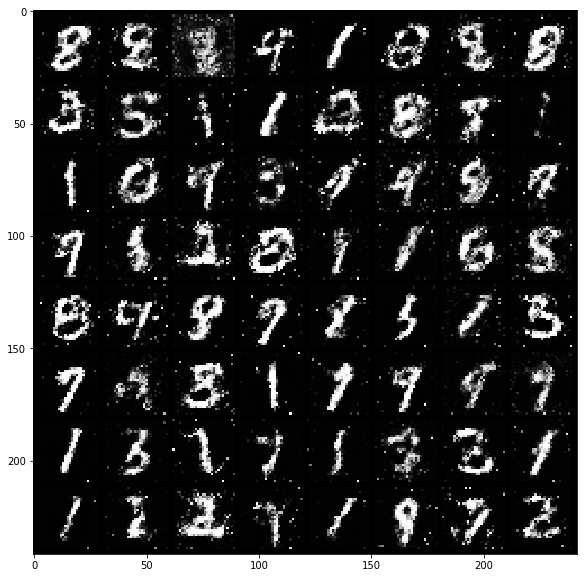

100%|██████████| 10001/10001 [21:36<00:00,  7.71it/s]


In [7]:
from tqdm import tqdm
G = Generator()
D = Discriminator()
G_lr = D_lr = 0.0002
optimizers = {
    'D': torch.optim.Adam(D.parameters(), lr=D_lr, betas=(0.5, 0.999)),
    'G': torch.optim.Adam(G.parameters(), lr=G_lr, betas=(0.5, 0.999))
}
criterion = nn.BCELoss()
for epoch in tqdm(range(10000+1)):
    data = next(iter(train_loader))[0]
    ones_label = Variable(torch.ones((data.size()[0], 1)))
    zeros_label = Variable(torch.zeros((data.size()[0], 1)))

    optimizers['D'].zero_grad()
    data = Variable(data)
    output_real = D(data)
    loss_real_G = criterion(output_real, ones_label)

    noisev = torch.randn(data.size()[0], z_size, 1, 1)
    noisev = Variable(noisev)
    fake_data = G(noisev)
    output_fake = D(fake_data)
    loss_fake_G = criterion(output_fake, zeros_label)

    loss_real = loss_real_G + loss_fake_G
    loss_real.backward()
    optimizers['D'].step()

    optimizers['G'].zero_grad()
    noisev = torch.randn(data.size()[0], z_size, 1, 1)
    noisev = Variable(noisev)
    fake_data = G(noisev)
    output_fake1 = D(fake_data)
    loss_fake_G = criterion(output_fake1, ones_label)
    loss_fake_G.backward()
    optimizers['G'].step()
    #     print(data[0])
    #     print('------------')
    #     print(fake_data[0])
    #     break

    if epoch % 1000 == 0:
        if torch.cuda.is_available():
            dd = utils.make_grid(fake_data.cpu().data[:64])
        else:
            dd = utils.make_grid(fake_data.data[:64])
        imshow(dd,'./results/GAN_%d.png'%(epoch))
        dd = dd.mul(0.5).add(0.5)
        vutils.save_image(dd, './results/OrGAN_%d.png'%(epoch))